## Training with regular and stability loss

Recent work have shown that deep neural networks are sensible to adversarial perturbations: slight modifications of outputs, generally lower than sensor sampling resolution, that have the effect to fool classifiers. Those perturbations have shown intriguing properties:
+ Perturbed image is most of the time indistinguishible from the normal image
+ Perturbations are network agnostic: a perturbation desgined for a specific architecture can as weel perturb another one
+ Perturbations can be found in real world: a perturbed image printed and captured with camera still fools a network

In the recent paper [Improving the Robustness of Deep Neural Networks via Stability Training](https://arxiv.org/pdf/1604.04326v1.pdf), authors show two important things:
+ Perturbations can appear in computer vision pipelines, when compression, down sampling, and cropping operations are performed
+ The addition of a stability term to the loss function allows to reduce the robustness of classifiers

Indeed, when training a neural network over a classification task, one classicly use a regularized cross correlation between label and network output:
$$
L_c(x,y,\theta) = -\sum_{j}y_j\log(f(x,\theta)_j) + \beta\sum_{i}\|\theta_i\|^2_2
$$
With $f(x,\theta)_j$, the j-th output of the network for sample $x$. 

To enforce robustness of the network, the authors propose to add a term that penalize output modifications for slight modifications of the input, i.e. to add distance between output for normal sample, and output for modified sample to the loss:
$$
L_s(x,y,\theta) = -\sum_{j}y_j\log(f(x,\theta)_j) - \alpha\sum_{j}f(x,\theta)_j\log(f(x',\theta)_j) + \beta\sum_{i}\|\theta_i\|^2_2
$$
With $x'$ the input image perturbed with gaussian noise. 

## Experiments

In this experiment, we are going to train classic LeNet5 architecture with classic and stabilized loss, and then assess the performance of each over perturbed samples.


In [1]:
import sys, os 
sys.path.append(os.getcwd()+'/../src')
sys.path.append(os.getcwd()+'/../data')

import numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import architectures
import cifar10
import utils
import callbacks

We import data:

In [2]:
X_train, y_train_lab = cifar10.load_cifar(dataset='training', path=os.getcwd()+'/../data/cifar')
X_train = numpy.reshape(X_train, [X_train.shape[0], -1])
X_train = X_train/255.
X_train.astype(numpy.float32)
y_train = utils.labels_to_categoricals(y_train_lab)

X_test, y_test_lab = cifar10.load_cifar(dataset='testing', path=os.getcwd()+'/../data/cifar')
X_test = numpy.reshape(X_test, [X_test.shape[0], -1])
X_test = X_test/255.
X_test = X_test.astype(numpy.float32)
y_test = utils.labels_to_categoricals(y_test_lab)

We check that the data is in expected shape:

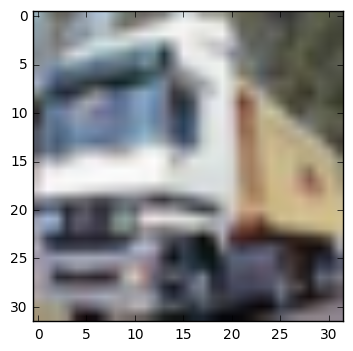

In [3]:
plt.imshow(numpy.reshape(X_train[1], [32,32,3]))

## Training Cifar Network with regular training
We first start by training a network with classic cross entropy loss

In [4]:
network = architectures.CifarNet(path_to_logs=os.getcwd()+'/Logs')

We define our callback:

In [5]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/ct_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/UnTuned", over_iter=1000)

And then we train the network:

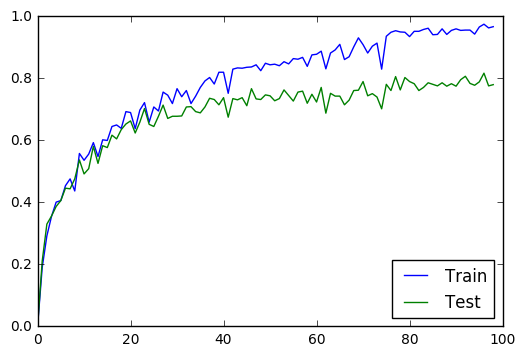

Number of iterations: 9900
Elapsed Time: 00:14:16
Last iteration duration: 8.72 seconds
Last train accuracy: 0.967000
Last test accuracy: 0.780000


In [6]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.1, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=7500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=2500, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

We plot the Loss

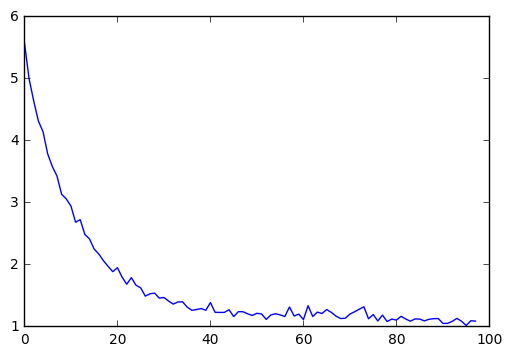

In [8]:
plt.plot(network.get_summaries(name="Loss/Loss_1"))
plt.savefig('Figures/ct_loss.pdf')

We plot the learning rate

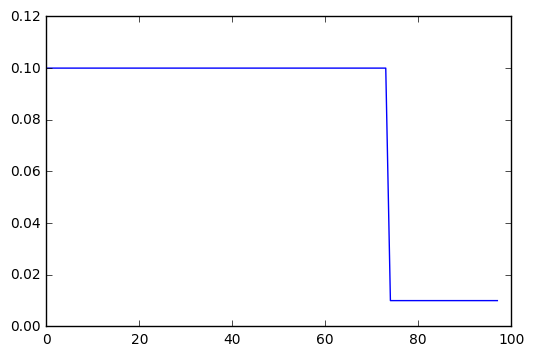

In [9]:
plt.plot(network.get_summaries(name="LearningRate_1"))
plt.savefig('Figures/ct_lr.pdf')

We save the network:

In [10]:
network.save("Networks/UnTuned")

We test the final accuracy over the whole test set

In [11]:
network.test(X_test, y_test)

0.7861

## Fine Tune With Regular Loss
We fine tune a network using regular cross entropy loss

In [14]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/ct_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/RegularTuned", over_iter=1000)

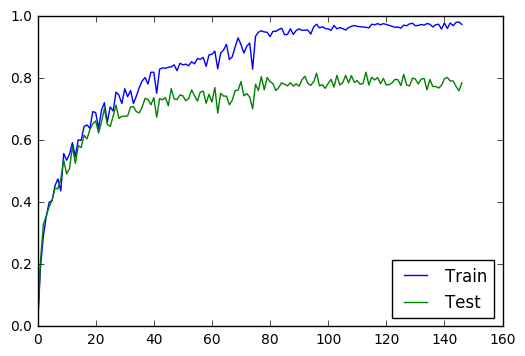

Number of iterations: 14700
Elapsed Time: 00:21:04
Last iteration duration: 8.51 seconds
Last train accuracy: 0.974000
Last test accuracy: 0.786000


In [15]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=4000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=1000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

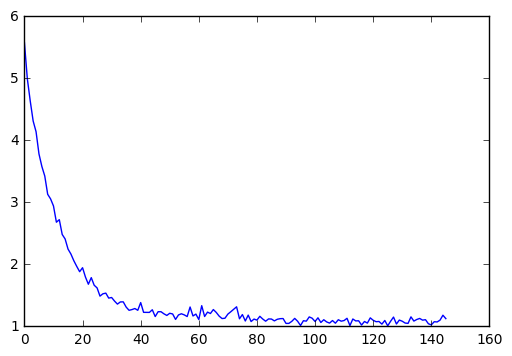

In [16]:
plt.plot(network.get_summaries(name="Loss/Loss_1"))
plt.savefig('Figures/ct_loss.pdf')

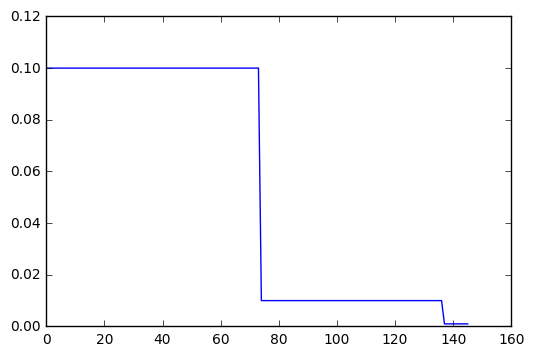

In [17]:
plt.plot(network.get_summaries(name="LearningRate_1"))
plt.savefig('Figures/ct_lr.pdf')

In [18]:
network.save("Networks/RegularTuned")

In [19]:
network.test(X_test, y_test)

0.7877

## Training Cifar Net with stabilized training
We train stabilized Cifar net with the following different configurations:
1. $\alpha$ = 0.01, $\sigma$ = 0.05
2. $\alpha$ = 0.01, $\sigma$ = 0.2
3. $\alpha$ = 0.1, $\sigma$ = 0.05

#### Configuration 1:  $\alpha$ = 0.01, $\sigma$ = 0.05

In [18]:
reload(architectures)
network = architectures.StabilizedCifarNet(path_to_logs=os.getcwd()+'/Logs')
network.load("Networks/UnTuned")
alpha = network.get_tensor('Alpha:0')
network.update_feed_dict_value(alpha,0.01, 'both')
stdv = network.get_tensor('NoiseStdv:0')
network.update_feed_dict_value(stdv,0.05, 'both')

In [19]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/st1_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/StabilityTuned1", over_iter=1000)

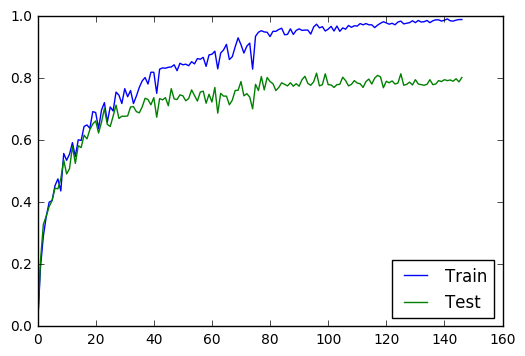

Number of iterations: 14700
Elapsed Time: 00:26:40
Last iteration duration: 15.57 seconds
Last train accuracy: 0.990000
Last test accuracy: 0.803000


In [20]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=4000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=1000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

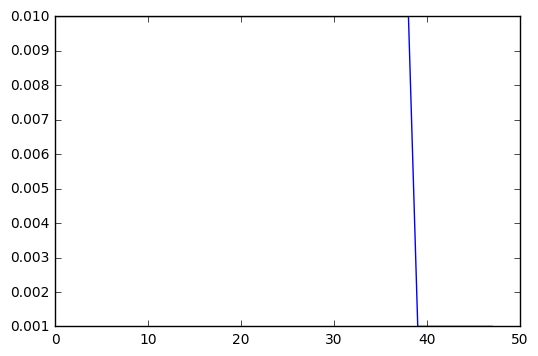

In [21]:
plt.plot(network.get_summaries('LearningRate_1'))
plt.savefig('Figures/st1_lr.pdf')

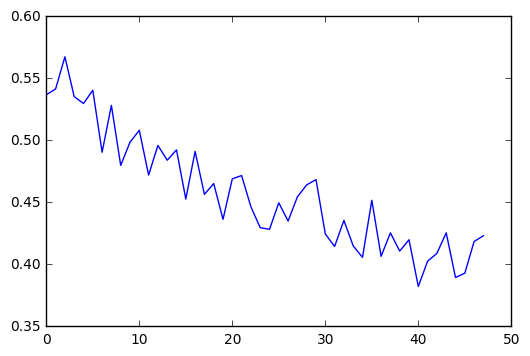

In [22]:
plt.plot(network.get_summaries('Loss/Stability_1'))
plt.savefig('Figures/st1_stability.pdf')

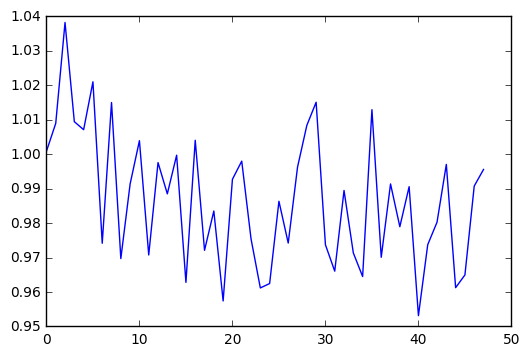

In [23]:
plt.plot(network.get_summaries('Loss/Loss_1'))
plt.savefig('Figures/st1_loss.pdf')

In [24]:
network.save('Networks/StabilityTuned1')

In [25]:
network.test(X_test, y_test)

0.7879

#### Configuration 2:  $\alpha$ = 0.01, $\sigma$ = 0.2

In [17]:
network = architectures.StabilizedCifarNet(path_to_logs=os.getcwd()+'/Logs')
network.load("Networks/UnTuned")
alpha = network.get_tensor('Alpha:0')
network.update_feed_dict_value(alpha,0.01, 'both')
stdv = network.get_tensor('NoiseStdv:0')
network.update_feed_dict_value(stdv,0.2, 'both')

In [18]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/st2_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/StabilityTuned2", over_iter=1000)

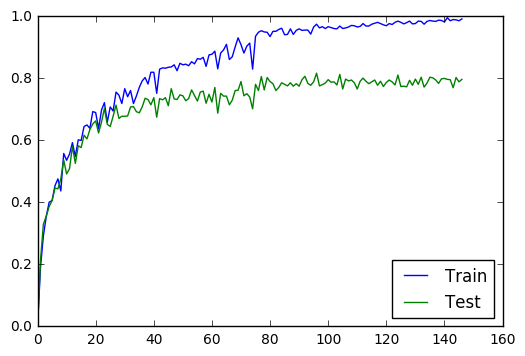

Number of iterations: 14700
Elapsed Time: 00:26:36
Last iteration duration: 15.45 seconds
Last train accuracy: 0.992000
Last test accuracy: 0.797000


In [19]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=4000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=1000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

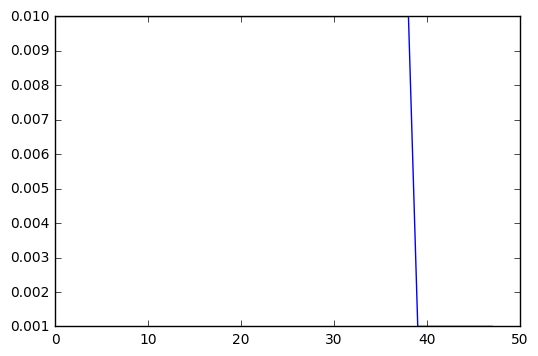

In [20]:
plt.plot(network.get_summaries('LearningRate_1'))
plt.savefig('Figures/st2_lr.pdf')

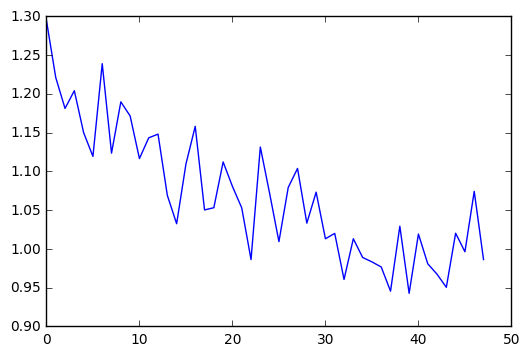

In [21]:
plt.plot(network.get_summaries('Loss/Stability_1'))
plt.savefig('Figures/st2_stability.pdf')

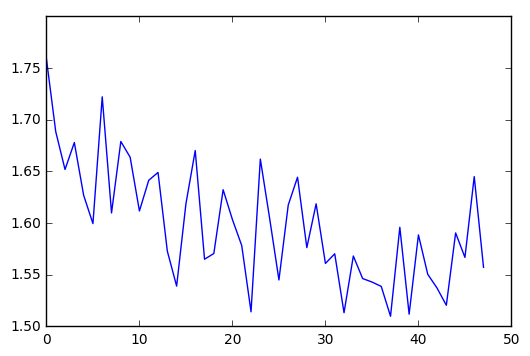

In [22]:
plt.plot(network.get_summaries('Loss/Loss_1'))
plt.savefig('Figures/st2_loss.pdf')

In [23]:
network.save('Networks/StabilityTuned2')

In [24]:
network.test(X_test, y_test)

0.789

#### Configuration 3:  $\alpha$ = 0.1, $\sigma$ = 0.05

In [26]:
network = architectures.StabilizedCifarNet(path_to_logs=os.getcwd()+'/Logs')
network.load("Networks/UnTuned")
alpha = network.get_tensor('Alpha:0')
network.update_feed_dict_value(alpha,0.1, 'both')
stdv = network.get_tensor('NoiseStdv:0')
network.update_feed_dict_value(stdv,0.05, 'both')

In [27]:
def callback(network):
    callbacks.ipython_clear_callback()
    callbacks.plot_callback(network, save_path='Figures/st3_training.pdf')
    callbacks.print_callback(network)
    callbacks.save_callback(network, "Networks/StabilityTuned3", over_iter=1000)

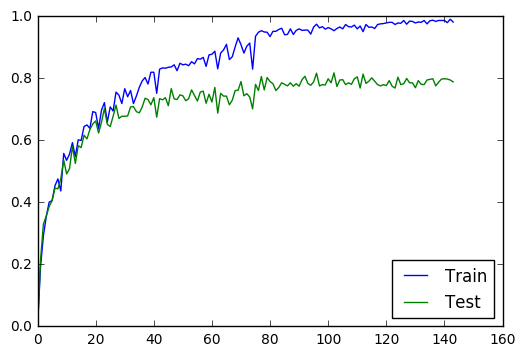

Number of iterations: 14400
Elapsed Time: 00:25:54
Last iteration duration: 15.50 seconds
Last train accuracy: 0.982000
Last test accuracy: 0.789000


In [ ]:
lr = network.get_tensor('LearningRate:0')
network.update_feed_dict_value(lr,0.01, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=4000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)
network.update_feed_dict_value(lr,0.001, 'both')
network.train(X_train, y_train, X_test, y_test, iterations=1000, 
              train_batch_size=1000, test_batch_size=1000, callback=callback)

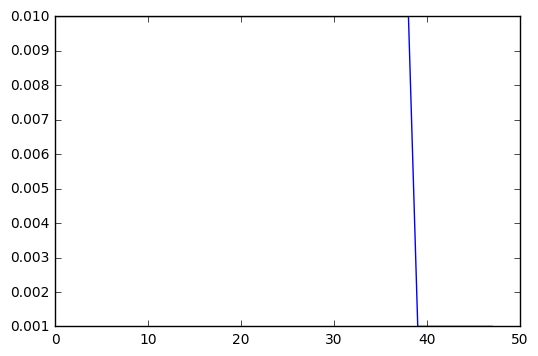

In [29]:
plt.plot(network.get_summaries('LearningRate_1'))
plt.savefig('Figures/st3_lr.pdf')

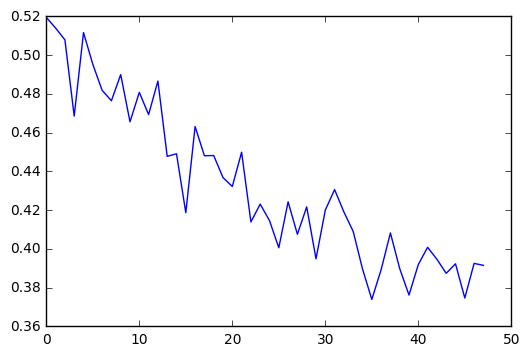

In [30]:
plt.plot(network.get_summaries('Loss/Stability_1'))
plt.savefig('Figures/st3_stability.pdf')

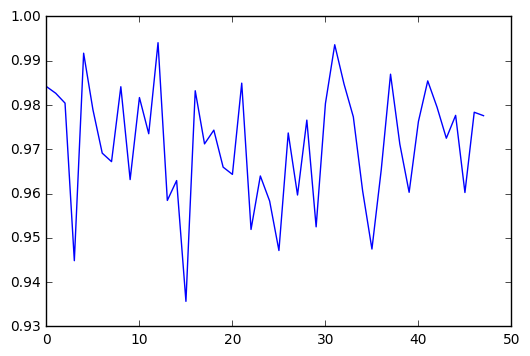

In [31]:
plt.plot(network.get_summaries('Loss/Loss_1'))
plt.savefig('Figures/st3_loss.pdf')

In [32]:
network.save('Networks/StabilityTuned3')

In [33]:
network.test(X_test, y_test)

0.7897